In [245]:
import pandas as pd
import numpy as np
import warnings
# Reproducibility
import random
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats to get trend
from statsmodels.tsa.seasonal import seasonal_decompose

# scikit-learn 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
# Tensorflow (for LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)


# Import data

In [248]:
path = r"C:\Users\TurnerJosh\Desktop\TestProj\GoodSalesData1.xlsx"
df = pd.read_excel(path)

In [260]:
df.shape

(8639, 10)

In [271]:
df = df[['Invoice Amount','Invoice Date']].loc[df['Invoice Amount'] != 0]
# Rename date series 'ds' and time series 'ts'
DF = df.rename(columns = {'Invoice Date': 'ds', 'Invoice Amount': 'ts'})

In [275]:
DF.isna().sum()


ts    0
ds    0
dtype: int64

# Initial Analysis

<Axes: xlabel='ds'>

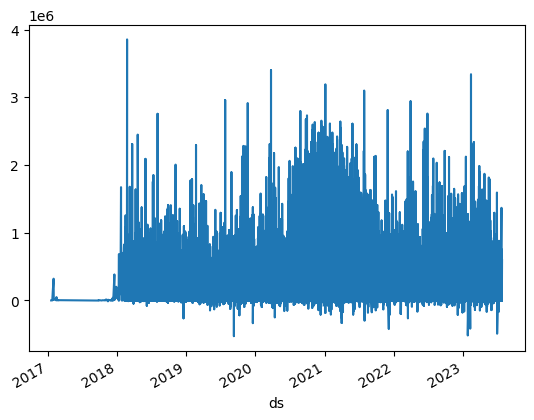

In [276]:
#Choose Time series
df1 = DF.copy()
df1.set_index('ds',inplace=True)
df1['ts'].plot()

# Dealing with outliers

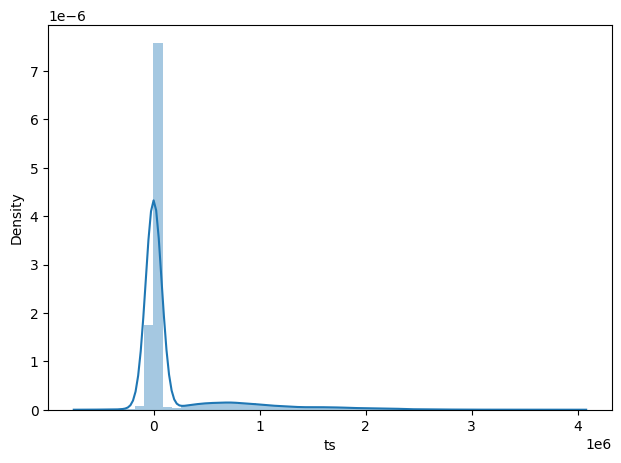

In [278]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(DF['ts'])
# plt.subplot(1,2,2)
# sns.distplot(df[''])
plt.show()

In [279]:
print("Highest allowed",DF['ts'].mean() + 3*DF['ts'].std())
print("Lowest allowed",DF['ts'].mean() - 3*DF['ts'].std())

Highest allowed 1537027.422062858
Lowest allowed -1189138.122026578


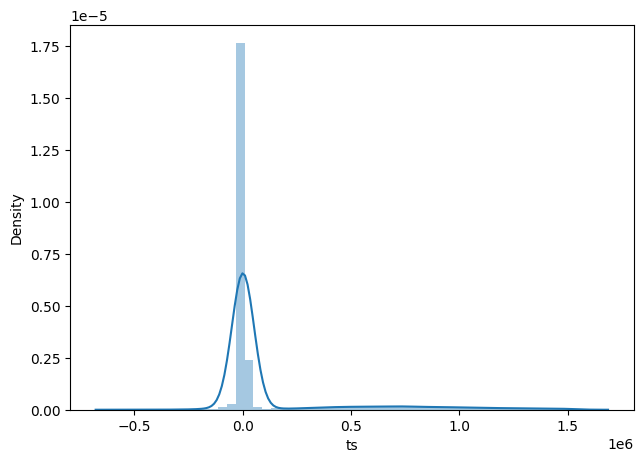

In [282]:
#Trim Outliers
new_df = DF["ts"][(DF['ts'] < DF['ts'].mean() + 3*DF['ts'].std()) & (DF['ts'] > DF['ts'].mean() - 3*DF['ts'].std())]
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(new_df)
# plt.subplot(1,2,2)
# sns.distplot(df[''])
plt.show()

## Skew

In [283]:
new_df.skew()

2.738505779969684

In [288]:
# Calculate logarithm to base 2 
# on 'Salary' column
new_df_log = np.log(new_df)
     

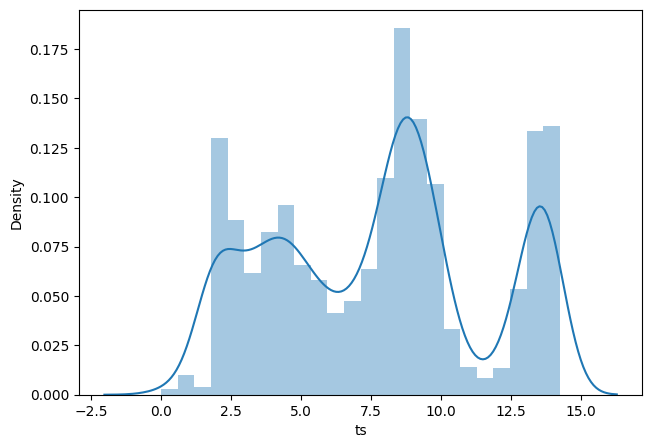

In [289]:

warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(new_df_log)
plt.show()

# Time Series Model

In [290]:
# Copy dataframe
DF['log_Sum_Unit_Price'] = np.log(DF['ts'])
DF = DF.copy()

In [291]:
# Drop nans
DF.dropna(inplace=True)

# Seasonal Decomposition

In [292]:
decomposition = seasonal_decompose(DF['ts'], period = 30, extrapolate_trend = 'freq')

In [293]:
Decom_Df = DF
Decom_Df.loc[:, "trend"] = decomposition.trend
Decom_Df.loc[:, "seasonal"] = decomposition.seasonal
Decom_Df.loc[:, "residual"] = decomposition.resid

In [294]:
def plot_decomposition(df, ts,trend,seasonal, residual):

  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

  ax1.plot(df[ts], label = 'Original', c = 'b')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend', c = 'lime')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality', c = 'm')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals', c = 'r')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  #plt.subtitle('Signal Decomposition of  %s' %(ts), x =0.5, y= 1.05, fontsize = 18)
  plt.show()

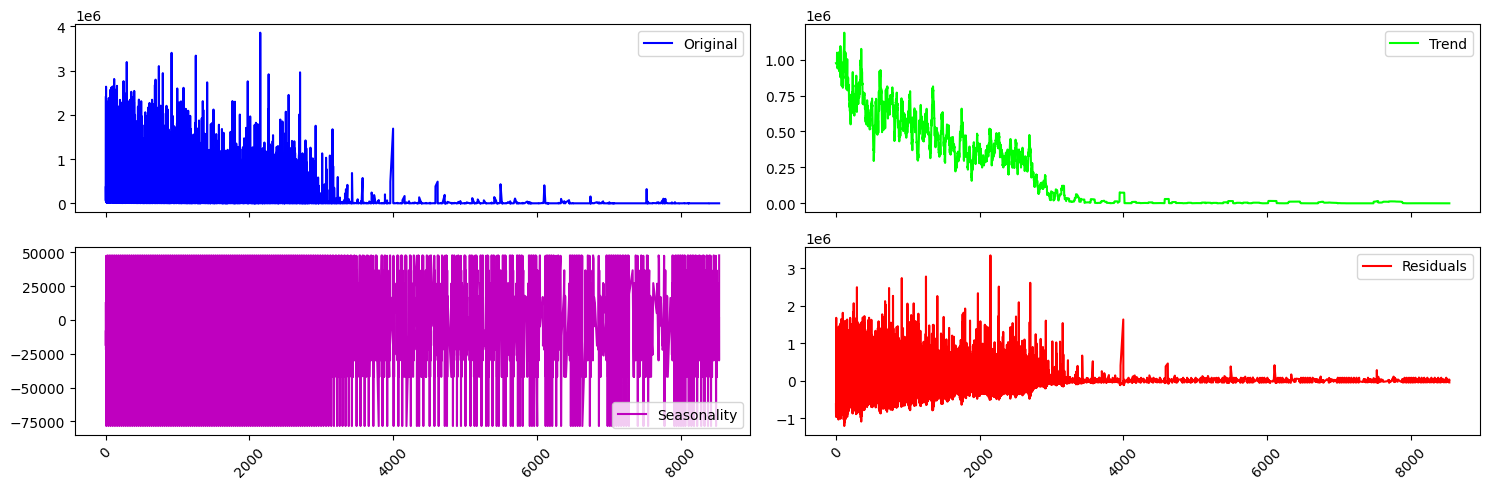

In [295]:
plot_decomposition(Decom_Df, ts = 'ts', trend = 'trend', seasonal = 'seasonal', residual = 'residual')

<Axes: >

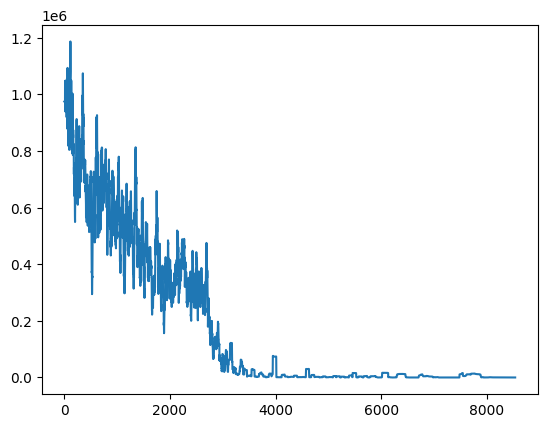

In [296]:
series = Decom_Df.loc[:, "trend"] 
+ Decom_Df.loc[:, "seasonal"] 
+ Decom_Df.loc[:, "residual"] 
series.plot()
# DF['ts'].plot()

In [299]:
r2_score(series, DF['ts'])

-1.307825310712531

# Subtracting out the trend

<Axes: >

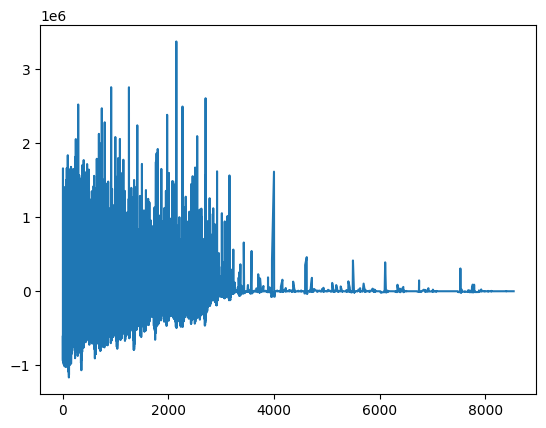

In [300]:
Decom_Df['No_Trend'] = Decom_Df.ts - Decom_Df.trend
Decom_Df.No_Trend.plot()
# Decom_Df.ts.plot()

# Apply different model on ts with trend subtracted

# An LSTM

## Data Prep

In [301]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
Decom_Df['No_Trend'] = scaler.fit_transform(Decom_Df[['No_Trend']])

# Create sequences of fixed length (e.g., 30 time steps)
sequence_length = 30

X, y = [], []
for i in range(len(Decom_Df) - sequence_length):
    X.append(Decom_Df['No_Trend'].iloc[i:i + sequence_length])
    y.append(Decom_Df['No_Trend'].iloc[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X.shape

(5937, 30, 1)

## Training and Testing Sets

In [302]:
#Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [303]:
X_test.shape

(1188, 30, 1)

## Model Architecture

In [304]:
# Create LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


## Model Training

In [305]:
# Train Model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))


Epoch 1/50
149/149 [==============================] - 5s 18ms/step - loss: 0.0134 - val_loss: 0.0097
Epoch 2/50
149/149 [==============================] - 2s 14ms/step - loss: 0.0089 - val_loss: 0.0096
Epoch 3/50
149/149 [==============================] - 2s 14ms/step - loss: 0.0087 - val_loss: 0.0094
Epoch 4/50
149/149 [==============================] - 2s 14ms/step - loss: 0.0087 - val_loss: 0.0093
Epoch 5/50
149/149 [==============================] - 2s 14ms/step - loss: 0.0086 - val_loss: 0.0093
Epoch 6/50
149/149 [==============================] - 2s 13ms/step - loss: 0.0086 - val_loss: 0.0096
Epoch 7/50
149/149 [==============================] - 2s 13ms/step - loss: 0.0087 - val_loss: 0.0091
Epoch 8/50
149/149 [==============================] - 2s 13ms/step - loss: 0.0086 - val_loss: 0.0092
Epoch 9/50
149/149 [==============================] - 2s 13ms/step - loss: 0.0086 - val_loss: 0.0091
Epoch 10/50
149/149 [==============================] - 2s 13ms/step - loss: 0.0085 - val_lo

## Model Predictions

In [306]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# Inverse transform the predictions to put in terms of sales
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


38/38 [==============================] - 0s 4ms/step


## Evaluation of Model Performance

In [307]:
# Evaluate Model
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 408784.6051700368
Test RMSE: 423390.3394940898


In [308]:
y_test_pred.shape,Decom_Df.trend.shape

((1188, 1), (5967,))

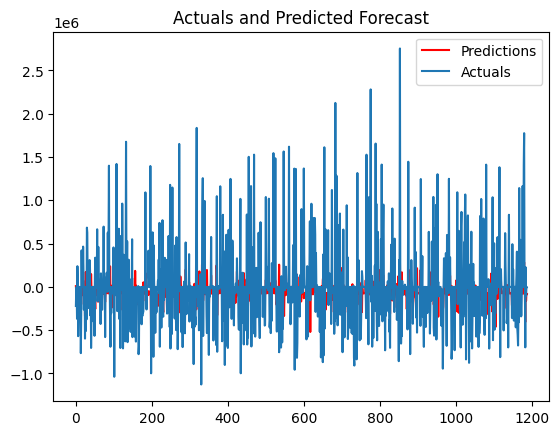

In [309]:
plt.plot(y_test_pred,c='red',label='Predictions')
plt.title('Actuals and Predicted Forecast')
plt.plot(y_test_actual,label='Actuals')
plt.legend()
plt.show()

In [310]:
# R2
r2_score(y_test_actual, y_test_pred)

0.08272281143858284

# XGBoost Model